# Project : Movielens 영화 SBR

- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점이다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있다. 그래서 이번에는 UserID가 SessionID 역할을 해야 한다.
- Rating 정보가 포함되어 있다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 한다.
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있다.

## Step 1. 데이터의 전처리

### 1-1. Data load

In [96]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [97]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [98]:
# utc시간 객체로 반환
from datetime import datetime
data['Time'] = data['Time'].apply(lambda x: datetime.fromtimestamp(x))

In [99]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [100]:
# 추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수와 아이템 수 이다.

data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### 1-2. User Length

In [101]:
# user_length란 같은 UserId를 공유하는 데이터 row의 개수를 의미한다.
# 따라서 여기서 user_length란 해당 세션의 사용자가 
# 그 세션 동안 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)의 의미가 된다.

user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [102]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [103]:
user_length.min(), user_length.max()

(20, 2314)

In [104]:
# 99.9% user 길이가 1343이하이다.

user_length.quantile(0.999)

1343.181000000005

In [106]:
long_user = user_length[user_length >= 1343].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
137631,889,1266,3,2000-11-26 14:11:02
137864,889,2430,3,2000-11-26 14:11:02
137889,889,1643,3,2000-11-26 14:11:02
138039,889,3461,3,2000-11-26 14:11:02
138316,889,1193,1,2000-11-26 14:11:02
...,...,...,...,...
138285,889,1322,1,2000-11-27 22:34:46
138292,889,1328,1,2000-11-27 22:34:46
139033,889,2974,2,2000-11-27 22:34:46
137720,889,3047,5,2000-11-27 22:35:18


In [107]:
# user 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해본다. 
# 아래는 user길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것이다.

user_count = user_length.groupby(user_length).size()
user_percent_cumsum = user_count.cumsum() / user_count.sum()
user_percent_cumsum_999 = user_percent_cumsum[user_percent_cumsum < 0.999]
user_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

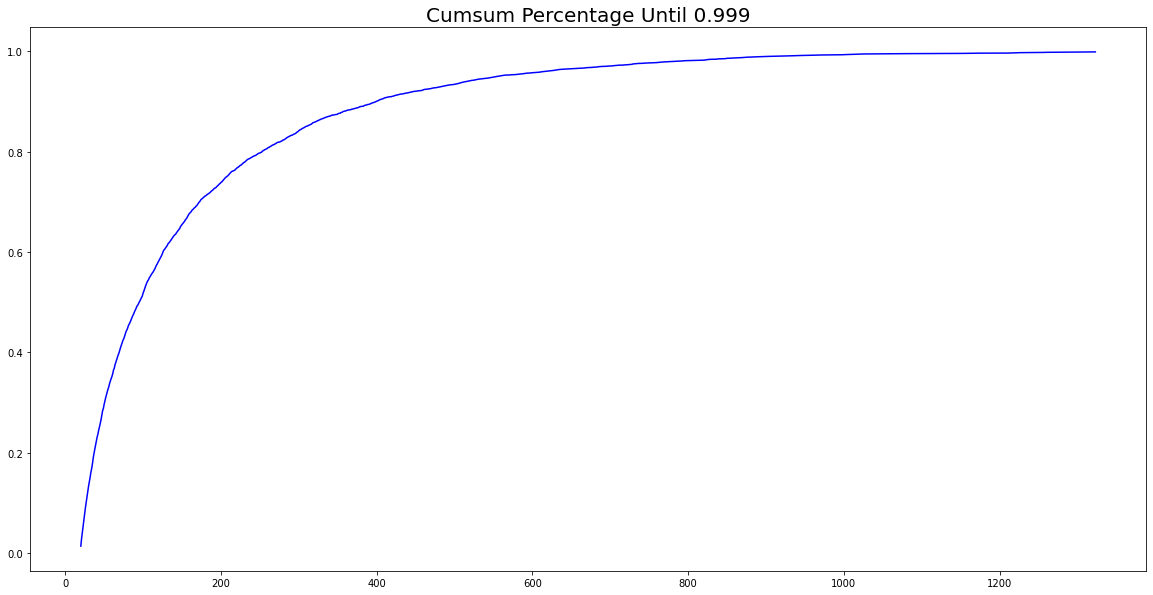

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(user_percent_cumsum_999.index,
       user_percent_cumsum_999, color='blue')
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 1-3. User Time

In [109]:
# 우리가 다루려는 데이터의 시간 관련 정보를 확인해 본다.

oldset, latest = data['Time'].min(), data['Time'].max()
print(oldset)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [110]:
# latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다.

type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [87]:
# 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용한다.

month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
28225,195,2808,3,2003-02-02 21:08:38
27759,195,1254,4,2003-02-06 17:23:42
27921,195,1456,2,2003-02-08 00:07:32
28443,195,468,3,2003-02-11 17:42:36
28255,195,2748,1,2003-02-11 18:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


### 1-4. Data Cleansing

In [111]:
# 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 
# 길이가 1인 user는 제거해준다.
# 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있다. 이 역시 제거해준다.

# short_user를 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 user가 생길 수 있다.
# 이를 위해 반복문을 통해 지속적으로 제거한다.

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data


In [112]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data.size

3998444

In [113]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### 1-5. Train/ Valid/ Test split

In [133]:
# data의 20%를 test로 사용할 것이다.
# 또한, train을 15%를 나눠 val로 사용할 것이다.

data_len = len(data)
print('data_len:', data_len)

# train, test를 나눠준다.
divide_point = int(data_len * 0.8)
data_tr_pre = data[:divide_point]
data_test = data[divide_point:]

# train에서 val를 추출한다.
divide_val_point = int(len(data_tr_pre) * 0.8)
data_tr = data_tr_pre[:divide_val_point]
data_val = data_tr_pre[divide_val_point:]

print('data_train:', len(data_tr))
print('data_test:', len(data_test))
print('data_val:', len(data_val))

data_len: 999611
data_train: 639750
data_test: 199923
data_val: 159938


In [134]:
# data에 대한 정보를 살펴본다.

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t User: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [136]:
stats_info(data_tr, 'train')
stats_info(data_val, 'valid')
stats_info(data_test, 'test')

* train Set Stats Info
	 Events: 639750
	 User: 3847
	 Items: 3416
	 First Time : 2000-08-10 04:09:32
	 Last Time : 2003-02-28 00:51:39

* valid Set Stats Info
	 Events: 159938
	 User: 949
	 Items: 3347
	 First Time : 2000-07-07 15:42:45
	 Last Time : 2003-02-27 14:22:07

* test Set Stats Info
	 Events: 199923
	 User: 1246
	 Items: 3329
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-28 17:49:50



In [137]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱한다

id2idx = {item_id : index for index, item_id in enumerate(data_tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해준다.
    return df

data_tr = indexing(data_tr, id2idx)
data_val = indexing(data_val, id2idx)
data_test = indexing(data_test, id2idx)

In [138]:
save_path = data_path / 'processed_pr'
save_path.mkdir(parents=True, exist_ok=True)

data_tr.to_pickle(save_path / 'train_pr.pkl')
data_val.to_pickle(save_path / 'valid_pr.pkl')
data_test.to_pickle(save_path / 'test_pr.pkl')

## Step 2. 미니 배치의 구성

### 2-1. UserDataset

In [139]:
# 데이터가 주어지면 User가 시작되는 인덱스를 담는 값과 User를 새로 인덱싱한 값을 갖는 클래스를 만든다.

class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [140]:
tr_dataset = UserDataset(data_tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [141]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 639349, 639419, 639750], dtype=int32)

In [143]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 3844, 3845, 3846])

### 2-2. UserDataLoader

In [144]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing user-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the users to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인
        """
        start : Index Where User Start
        end : Index Where User End
        mask : indicator for the users to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Users
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져온다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둔다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져온다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져온다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것이다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수이다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update한다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해준다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 user가 끝났다는 뜻이다. mask에 기록해준다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것이다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것이다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록한다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 세션의 위치를 기록해둔다.
        return start, end, mask, last_user, finished

In [145]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [146]:
iter_ex = iter(tr_data_loader)

In [147]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

### 3-1.  Evaluation Metric

In [148]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]m
    return int(answer)

### 3-2. Model Architecture

In [149]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [150]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [151]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리한다.

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = data_tr['ItemId'].nunique()
        self.num_users = data_tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(data_tr, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [152]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### 3-3. Model Training

In [153]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화한다. 아래 메서드에서 확인

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증한다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져온다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져온다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 한다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드이다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 한다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

## Step 4. 모델 학습

In [154]:
train_model(model, args)

Train:   0%|          | 0/2483 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.53] 

	 - Recall@20 epoch 1: 0.124636
	 - MRR@20    epoch 1: 0.029687



Train:   0%|          | 0/2483 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.92] 

	 - Recall@20 epoch 2: 0.239656
	 - MRR@20    epoch 2: 0.061987



Train:   0%|          | 0/2483 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.49] 

	 - Recall@20 epoch 3: 0.276579
	 - MRR@20    epoch 3: 0.075649



Train:   0%|          | 0/2483 [00:00<?, ?it/s, accuracy=0.0977, train_loss=5.53] 

	 - Recall@20 epoch 4: 0.297567
	 - MRR@20    epoch 4: 0.083844



Evaluation:  69%|██████▉   | 429/621 [09:21<04:11,  1.31s/it]

	 - Recall@20 epoch 5: 0.310406
	 - MRR@20    epoch 5: 0.089912



## Step 5. 모델 테스트

In [156]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  77%|███████▋  | 595/776 [13:00<03:57,  1.31s/it]

	 - Recall@20: 0.282852
	 - MRR@20: 0.075072

